# Game of Life


The [Game of Life](http://en.wikipedia.org/wiki/Conway's_Game_of_Life) (GoF) is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by underpopulation.
* Any live cell with more than three live neighbours dies, as if by overcrowding.
* Any live cell with two or three live neighbours lives, unchanged, to the next generation.
* Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern (generation 0) constitutes the "seed" of the system.
Time is considered discrete, and each time step (sometimes called a tick), the previous rules are applied simultaneously to every cell in the grid; "births" and "deaths" are immediate.
Each generation is a pure function of the previous generation alone.


## Assignments

* Begin by implementing the GoF's rules and create few examples with basic seeds in small dimensions. Hint: create `.gif` animations from sequences of still `.png` images
* Implement examples of the three categories of patterns *still lifes*, *oscillators* and *spaceships* (check the [wiki link](http://en.wikipedia.org/wiki/Conway's_Game_of_Life))
* Analyse the evolutions of these patterns in terms of frequency (the number of cycles required to return to the original configuration, if any), occupancy (how many alive cells there are at every step of the game), replication or heat (the average number of cells that change state at each generation), speed (if applicable), etc.
* Increase the size of the GoF's world and play with more advanced and complex patterns

# Game of Life implementation
To implement the Conway's Game of Life we create 3 functions:
1. __update__: this function handles all the logic of the game and it's built to allows us to run some analysis on the evolution of the game.
   1. It takes the present state (grid) and compute the future state (newGrid) according to the game's rules
   2. If the _heat_ argument is passed, it computes the difference in occupancy between present and future grid, keeping track of changes and averaging it at the end of the animation
   3. If _cycle_ and _initial_grid_ arguments are passed, it checks if the new computed condition is equal to the starting one, keeping track of when it happens
   4. If the _occupancy_ argument is passed, it calculate how many cells are alive at that step
2. __loadPattern__: this function allows us to import patterns written in txt file, saving us the time to manually implement them.
3. __saveFrame__: this function saves a particular frame of the Game of Life animation

In [1]:
# Imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from functools import partial

# TODO:
# Analyse the speed of the patterns (if possible)
# Add and analyse mrore advanced patterns
# Add documentation

In [2]:
# Parameters
ON = 255  # Alive cell value
OFF = 0   # Dead cell value

n_steps = 50 # Number of steps done in the game
inter = 100 # Time in ms between each frame (step of the game) in the GIF

def update(frame_num, img, grid, initial_grid=None, cycle=None, occupancy=None, heat=None):
    # Create a new grid for future state
    newGrid = grid.copy()

    # Save the number of rows and columns
    Nr = grid.shape[0]
    Nc = grid.shape[1]
    
    for i in range(Nr):
        for j in range(Nc):
            # For each cell in the grid it calculate the number of neighbouring alive cells
            total = int((grid[i, (j-1)%Nc] + grid[i, (j+1)%Nc] +
                         grid[(i-1)%Nr, j] + grid[(i+1)%Nr, j] +
                         grid[(i-1)%Nr, (j-1)%Nc] + grid[(i-1)%Nr, (j+1)%Nc] +
                         grid[(i+1)%Nr, (j-1)%Nc] + grid[(i+1)%Nr, (j+1)%Nc]) / ON)

            if grid[i, j] == ON:
                if (total < 2) or (total > 3):
                    newGrid[i, j] = OFF
            else:
                if total == 3:
                    newGrid[i, j] = ON

    img.set_data(newGrid)

    # Keep track of how many cells change state
    if heat is not None and frame_num > 0:
        heat.append(np.sum(np.not_equal(grid,newGrid)))

        # Average over the total number of steps in the first position
        if frame_num == n_steps-1:
            heat[0] = np.sum(heat[1:]) / n_steps

    # Update the grid
    grid[:] = newGrid[:]

    # Check if the patterns has cycled or not
    if initial_grid is not None and cycle is not None:
        cycle.append(1 if np.array_equal(grid,initial_grid) else 0)

    # Count how many alive cell
    if occupancy is not None:
        occupancy.append(np.sum(grid == ON))
    
    return img


def loadPattern(file_path, rows=None, columns=None, loc=(0,0)):
    # Open file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Remove whitespaces and ignore lines starting with '!'
    lines = [line.strip() for line in lines if not line.startswith('!')]

    # Check if the number of rows and columns were specified
    if rows == None:
        rows = len(lines)
    if columns == None:
        columns = max(len(line) for line in lines) 
    
    # Pad shorter lines with zeros to make them equal in length
    max_length = max(len(line) for line in lines) 
    lines_padded = [line.ljust(max_length, '.') for line in lines]
    
    # Create the grid and the pattern
    grid = np.zeros((rows, columns))
    pattern = np.array([[0 if cell == '.' else 255 for cell in line] for line in lines_padded])
    
    # Check if parameters are ok
    if loc[0] > rows or loc[1] > columns:
        raise ValueError("Invalid location parameter")
    
    if loc[0] + pattern.shape[0] > rows or loc[1] + pattern.shape[1] > columns:
        raise ValueError("The pattern overflows the grid")
    
    # Put the pattern in the grid
    grid[loc[0]:loc[0]+pattern.shape[0], loc[1]:loc[1]+pattern.shape[1]] = pattern
    
    # Return the grid
    return grid


def saveFrame(frameNum, img):
    plt.savefig(f'gof_frame_{frameNum:03d}.png', format='png')
    return img

# Random example
In this section we initialize the game with a randomly filled grid and let it evolve.

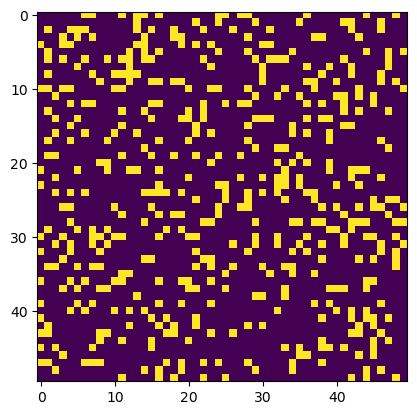

In [3]:
# Random generation example
N = 50
random_grid = np.random.choice([ON, OFF], N*N, p=[0.2, 0.8]).reshape(N, N)

# How many alive cells at each step
random_occupancy = []

# Average of the cells that change state at each step
random_heat = [0];

# Plot generation
fig, ax = plt.subplots()
img = ax.imshow(random_grid, interpolation='nearest')
plt.plot()

# Set up the animation
random_out = animation.FuncAnimation(fig, 
                            partial(update, img=img, grid=random_grid, occupancy=random_occupancy, heat=random_heat),
                            frames=n_steps, interval=inter,
                            init_func=lambda: saveFrame(0, img))

In [4]:
# Save and show animation
gif_name = 'random_example.gif'
random_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

The average number of cells that change state at each generation is 283.08


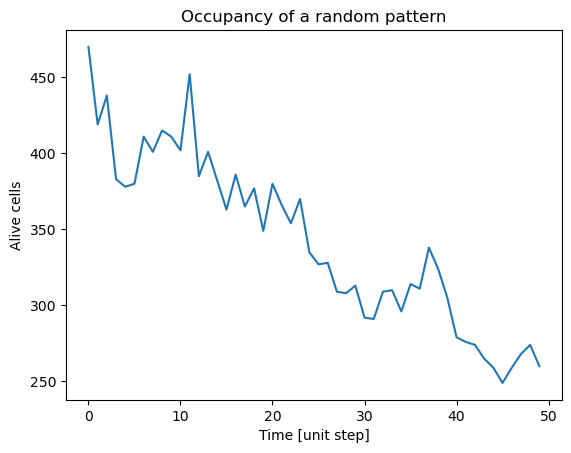

In [5]:
fig, ax = plt.subplots()
ax.plot(range(n_steps), random_occupancy)
ax.set_xlabel("Time [unit step]")
ax.set_ylabel('Alive cells')
plt.title('Occupancy of a random pattern')
print('The average number of cells that change state at each generation is', random_heat[0])

# Still life example
In this section we show a particular starting situation called _Still life_.<br>
As its name suggest, with this initial conditions the game doesn't evolve: the alive cells are always the same both in number and in location, it's an equiibrium point.

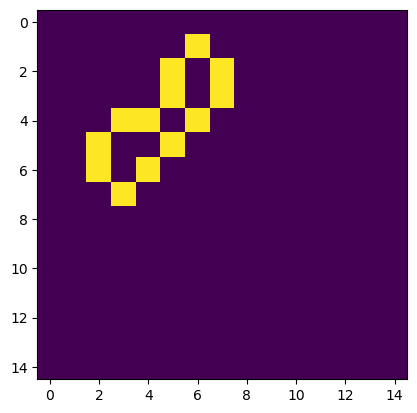

In [6]:
# Still life example (period 1)

# Load patterns from file.
# Patterns can be find at https://conwaylife.com/patterns/ (Download the .cells file and save as .txt)
still_pattern = 'beehiveatloaf.cells.txt'

still_grid = loadPattern(still_pattern, 15, 15, (1, 2))

# Plot generation
fig, ax = plt.subplots()
img = ax.imshow(still_grid, interpolation='nearest')
plt.plot()

# Set up the animation
still_out = animation.FuncAnimation(fig, partial(update, img=img, grid=still_grid),
                            frames=n_steps, interval=inter,
                            init_func=lambda: saveFrame(0, img))

In [7]:
# To save the animation as a GIF using Pillow
gif_name = 'beehiveatloaf.gif'
still_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

# Glider example
In this section we show and analyze another starting condition, known as _Glinder_ for its similarity with an animation of an object flying in the sky.

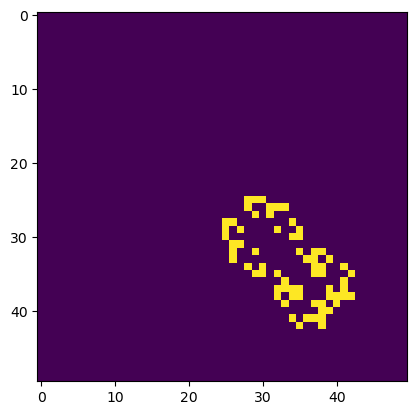

In [8]:
# Glider example

# Load patterns from file.
# Patterns can be find at https://conwaylife.com/patterns/ (Download the .cells file and save as .txt)
glider_pattern = 'bigglider.cells.txt'

glider_grid = loadPattern(glider_pattern, 50, 50, (25,25))

# How many alive cells at each step
glider_occupancy = []

# Average of the cells that change state at each step
glider_heat = [0];

# Plot generation
fig, ax = plt.subplots()
img = ax.imshow(glider_grid, interpolation='nearest')
plt.plot()

# Set up the animation
glider_out = animation.FuncAnimation(fig, 
                            partial(update, img=img, grid=glider_grid, occupancy=glider_occupancy, heat=glider_heat),
                            frames=n_steps, interval=inter,
                            init_func=lambda: saveFrame(0, img))

In [9]:
# To save the animation as a GIF using Pillow
gif_name = 'bigglider.gif'
glider_out.save(gif_name, writer='pillow', fps=4)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

The average number of cells that change state at each generation is 59.6


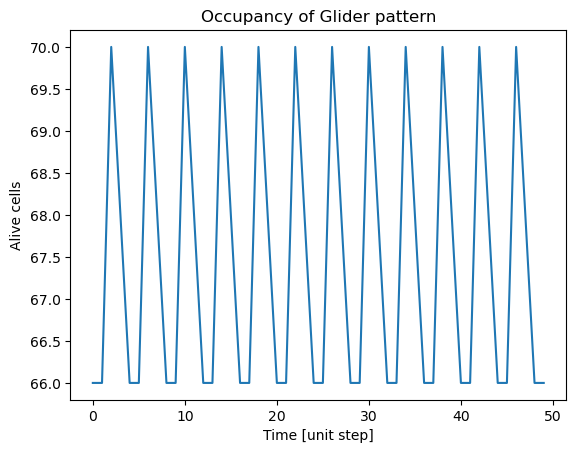

In [10]:
fig, ax = plt.subplots()
ax.plot(range(n_steps), glider_occupancy)
ax.set_xlabel("Time [unit step]")
ax.set_ylabel('Alive cells')
plt.title('Occupancy of Glider pattern')
print('The average number of cells that change state at each generation is', glider_heat[0])

# Analysis of "Glider" configuration
In this case we have a change in the occupancy of the grid, this occupancy follows a cyclic pattern.
TO ADD

# Oscillator example
In this section we have the _Oscillator_ configuration, a configuration which repeats itself over and over again.

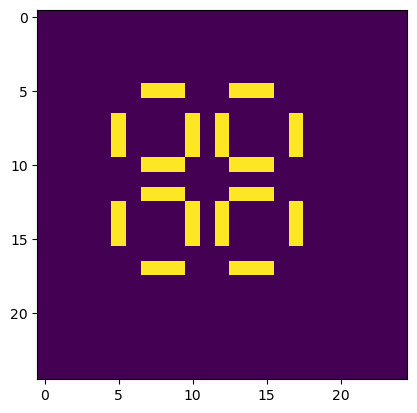

In [11]:
# Oscillator example (period 3)

# Load patterns from file.
# Patterns can be find at https://conwaylife.com/patterns/ (Download the .cells file and save as .txt)
pulsar = 'pulsar_cells.cells.txt'

pulsar_grid = loadPattern(pulsar, 25,25, (5,5))

# Original configuration
pulsar_igrid = pulsar_grid.copy() 

# List of cycle flags: 
# the i-th element is 1 if the pattern returned to the original configuration at step i; 
# 0 otherwise
pulsar_cycle = []

# How many alive cells at each step
pulsar_occupancy = []

# Average of the cells that change state at each step
pulsar_heat = [0];

# Plot generation
fig, ax = plt.subplots()
img = ax.imshow(pulsar_grid, interpolation='nearest')
plt.plot()

pulsar_out = animation.FuncAnimation(fig, 
                            partial(update, img=img, grid=pulsar_grid, initial_grid=pulsar_igrid, 
                                    cycle=pulsar_cycle, occupancy=pulsar_occupancy, heat=pulsar_heat),
                            frames=n_steps, interval=inter,
                            init_func=lambda: saveFrame(0, img))

In [12]:
# To save the animation as a GIF using Pillow
gif_name = 'pulsar_period3.gif'
pulsar_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

The average number of cells that change state at each generation is 41.6
[41.6, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32, 40, 56, 32]


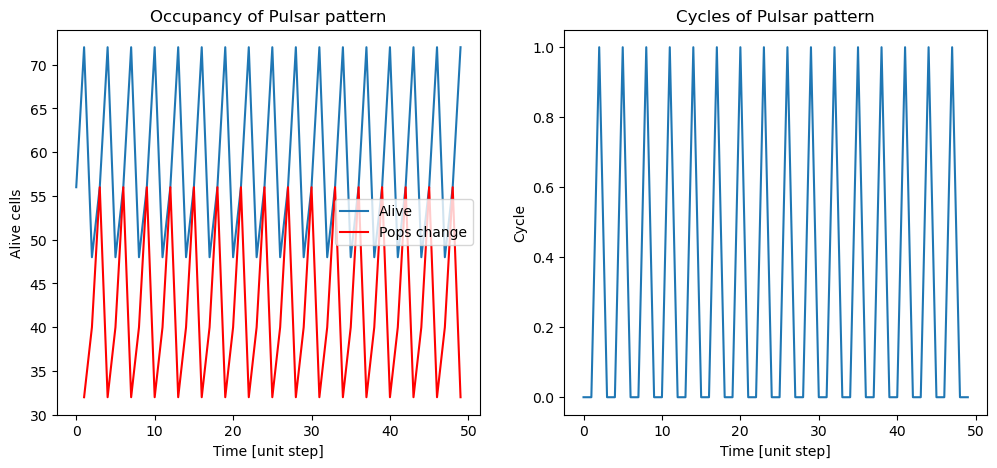

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,5),nrows=1,ncols=2)
ax1.plot(range(n_steps), pulsar_occupancy, label="Alive")
ax1.plot(range(n_steps)[1:], pulsar_heat[1:], 'r', label="Pops change")
ax1.set_xlabel("Time [unit step]")
ax1.set_ylabel('Alive cells')
ax1.set_title('Occupancy of Pulsar pattern')
ax1.legend()

ax2.plot(range(n_steps), pulsar_cycle)
ax2.set_xlabel("Time [unit step]")
ax2.set_ylabel('Cycle')
ax2.set_title('Cycles of Pulsar pattern')

print('The average number of cells that change state at each generation is', pulsar_heat[0])
print(pulsar_heat)

# Analysis of "Oscillator" configuration
As stated by it's name we have a configuration which repeats itself always with the same speed and with the same pattern.
TO ADD